In [1]:
## ALarsen working notebook

In [2]:
## Ignorning warnings

import warnings
warnings.filterwarnings("ignore")

## All other imports we'll use throughout this notebook

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import datetime
import random


In [3]:
!pwd

/Users/adamlarsen/Documents/Flatiron/phase-4/Project_4_new/TimeSeriesP4


In [4]:
df = pd.read_csv('DJIA_equities/CSCO_2006-01-01_to_2018-01-01.csv')

In [5]:
df.head(15)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
1,2006-01-04,17.48,17.93,17.46,17.85,80409776,CSCO
2,2006-01-05,17.94,18.48,17.93,18.35,118588943,CSCO
3,2006-01-06,18.51,18.88,18.47,18.77,122450979,CSCO
4,2006-01-09,18.97,19.11,18.92,19.06,78604868,CSCO
5,2006-01-10,18.87,19.15,18.78,18.97,73839465,CSCO
6,2006-01-11,18.98,19.43,18.94,19.40,73964864,CSCO
7,2006-01-12,19.27,19.35,19.08,19.20,59581203,CSCO
8,2006-01-13,19.13,19.33,18.89,18.92,52389265,CSCO
9,2006-01-17,18.70,18.78,18.47,18.68,53133127,CSCO


In [6]:
df.info()

# Looks like we need to convert the date column which is currently an object
# into a datetime object and then make that our index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d',)

df.info()

# Now lets try and make this our index before looking at our columns and what we should drop

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB


In [8]:
df.set_index('Date', inplace=True)

# Looks like index is now set to a date time object, lets drop open, high, low, volume and name
# so that we're only left with close and the day. 

# I think we'll want to resample this data later adding open to the morning price however we'll begin
# modeling now and revisit after results.

In [9]:

type(df)

pandas.core.frame.DataFrame

In [10]:
df = pd.Series(df['Close'], index=df.index)

Date
2006-01-03    17.45
2006-01-04    17.85
2006-01-05    18.35
2006-01-06    18.77
2006-01-09    19.06
Name: Close, dtype: float64


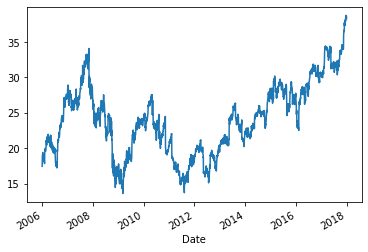

In [11]:
print(df.head())

df.plot();

# This should look like a pandas series, which it does. Let's check how this looks on a graph.

In [12]:
## Let's look at the Dickey-Fuller results to see how stationary it is. This doesn't
## look stationary at all however let's see how this looks.

def dickey(df_df):
    results = adfuller(df_df)

    p_value = results[4]['5%']

    print(f' The test statistic is: {results[0]}')
    print(f' The critical value when alpha is 5% is: {p_value}')
    return


In [13]:
split = round(df.shape[0]*0.8)
split


2415

(2415,)
(604,)
3019


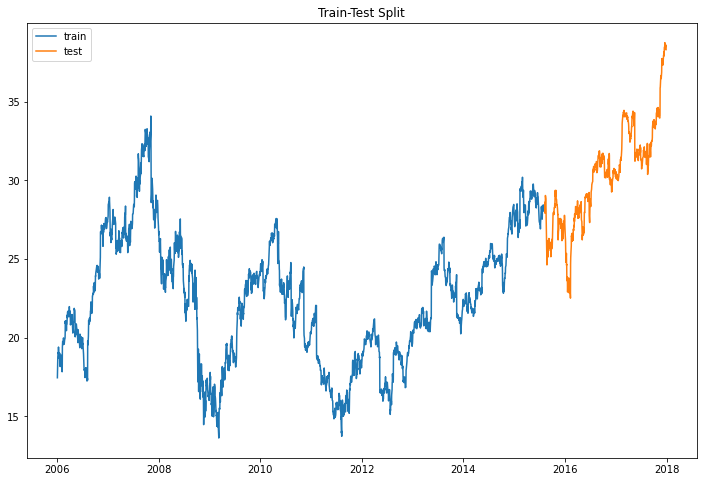

In [14]:
train = df[:split]
test = df[split:]

print(train.shape)
print(test.shape)
print(len(train) + len(test))

# Looks like our train test split was successful and we have created two buckets of data, one
# that we'll ultimately train our data on and one that we'll see how it performs on the unseen data.

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [15]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [16]:
x_val_split = TimeSeriesSplit()

for train_val, train_val_test in x_val_split.split(train):
    print(train_val, train_val_test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [17]:
log_price_train = np.log(train)
log_price_train

train_log = pd.Series(log_price_train, index=train.index)
train_log

Date
2006-01-03    2.859340
2006-01-04    2.882004
2006-01-05    2.909630
2006-01-06    2.932260
2006-01-09    2.947592
                ...   
2015-08-03    3.344980
2015-08-04    3.333275
2015-08-05    3.341801
2015-08-06    3.339677
2015-08-07    3.337547
Name: Close, Length: 2415, dtype: float64

 The test statistic is: -2.2184072127795202
 The critical value when alpha is 5% is: -2.862739030792749


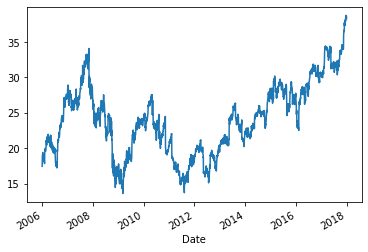

In [18]:
dickey(train)
df.plot();

 The test statistic is: -2.2921723977049746
 The critical value when alpha is 5% is: -2.862739030792749


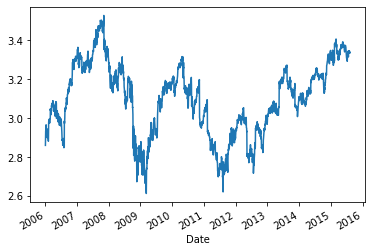

In [19]:
dickey(train_log)
train_log.plot();

Certainly getting closer however still not happy with the results given that it is not considered stationary. Let's try taking the square root of the price and see if that helps in any way shape or form.

 The test statistic is: -2.2428548830913755
 The critical value when alpha is 5% is: -2.862739030792749


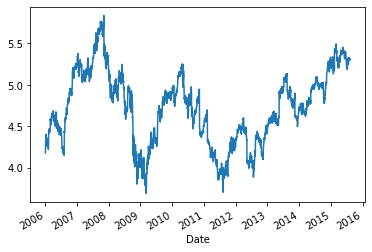

In [20]:
sqrt_price = np.sqrt(train)
df_sqrt_train = pd.Series(sqrt_price, index=train.index)
dickey(df_sqrt_train)
df_sqrt_train.plot();


The square root didn't seem to help all given that the test statistic came back lower than the log transformation. I also think it's important to note here that it doesn't seem like any exponential growth so as expected, these functions shouldn't have improved it much.

Let's try looking at the rolling mean and then seeing how much that helps our model.

 The test statistic is: -36.89467794577695
 The critical value when alpha is 5% is: -2.862739030792749
 The test statistic is: -19.441469989043735
 The critical value when alpha is 5% is: -2.862742022728184
 The test statistic is: -5.038716186368007
 The critical value when alpha is 5% is: -2.8627839262289756
 The test statistic is: -8.848055743452939
 The critical value when alpha is 5% is: -2.862752613124175
 The test statistic is: -6.310894715865046
 The critical value when alpha is 5% is: -2.862768070104647


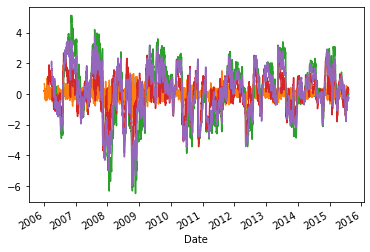

In [21]:
df_rolling = train.rolling(window=2).mean()
df_rolling_1 = train.rolling(window=4).mean()
df_rolling_2 = train.rolling(window=90).mean()
df_rolling_3 = train.rolling(window=30).mean()
df_rolling_4 = train.rolling(window=60).mean()

list_of_df = [df_rolling, df_rolling_1, df_rolling_2, df_rolling_3, df_rolling_4]

for i in list_of_df:
    if_df = (df - i).dropna()
    dickey(if_df)
    if_df.plot();



Looks like when we use a rolling mean of 2, our test statistic is very small (and is the smallest) which means we can reject the null and now assume our dataset is now stationary. 

The above graph looks to be pretty stationary and is further confirmed by the Dickey Fuller test where the test statistic was less than the critical value at 5%. I will try running some weighted moving average to see if that helps in any way.

In [22]:
weighted_average = df.ewm(halflife=2).std()
weighted_average_2 = df.ewm(halflife=2).mean()

 The test statistic is: -1.6123127723274686
 The critical value when alpha is 5% is: -2.8624984712561274


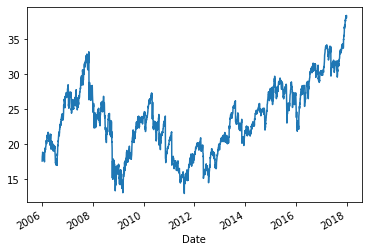

In [23]:
test_2 = (df-weighted_average).dropna()
dickey(test_2)
test_2.plot();

 The test statistic is: -24.19528224756999
 The critical value when alpha is 5% is: -2.8624981535161758


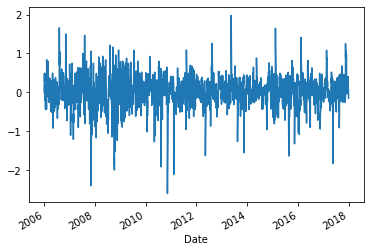

In [24]:
test_3 = (df-weighted_average_2).dropna()
dickey(test_3)
test_3.plot();

In [25]:
dickey(train.diff(periods=5).dropna())

 The test statistic is: -8.921889190266416
 The critical value when alpha is 5% is: -2.8627541412908255


In [26]:
period = [i for i in range(10)]
period

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
for i in period:
    dickey(train.diff(periods=i).dropna())

 The test statistic is: nan
 The critical value when alpha is 5% is: -2.8627380367880577
 The test statistic is: -36.89467794577721
 The critical value when alpha is 5% is: -2.862739030792749
 The test statistic is: -9.390477430502342
 The critical value when alpha is 5% is: -2.862752613124175
 The test statistic is: -8.80875858400221
 The critical value when alpha is 5% is: -2.8627531220854534
 The test statistic is: -9.516393753229009
 The critical value when alpha is 5% is: -2.8627536314741575
 The test statistic is: -8.921889190266416
 The critical value when alpha is 5% is: -2.8627541412908255
 The test statistic is: -8.650810911292682
 The critical value when alpha is 5% is: -2.8627536314741575
 The test statistic is: -9.652858311293087
 The critical value when alpha is 5% is: -2.862755162210213
 The test statistic is: -8.090203283910617
 The critical value when alpha is 5% is: -2.8627541412908255
 The test statistic is: -7.403108006747742
 The critical value when alpha is 5% is:

Interestingly enough, the diff of 2 is the exact same results of rolling average of 2 which seems like it's the exact same approach. We'll assume that is our best stationary model.

(-36.89467794577695, 0.0, 1, 2412, {'1%': -3.433064043542036, '5%': -2.862739030792749, '10%': -2.567408293778482}, -724.8894002644656)


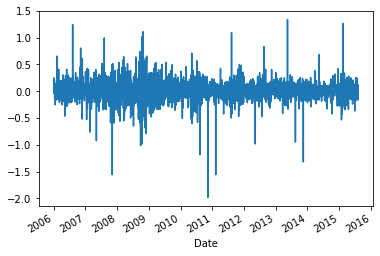

In [28]:
stationary = (train-df_rolling).dropna()
print(adfuller(stationary))
stationary.plot();

The above graph looks to be pretty stationary and is further confirmed by the Dickey Fuller test where the test statistic was less than the critical value at 5%. I will try running some weighted moving average to see if that helps in any way.



Want to take a look at trying to come up with ACF and PACF graphs to see how correlated our models are on past or lagged data. This would help give us an idea of what models would be a better fit going forward.

Now that we have a best model called Stationary, let's begin trying to throw in some models.

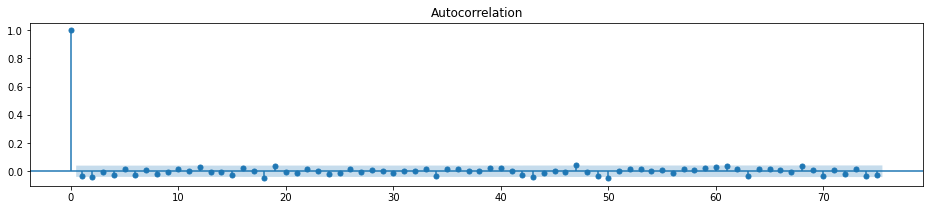

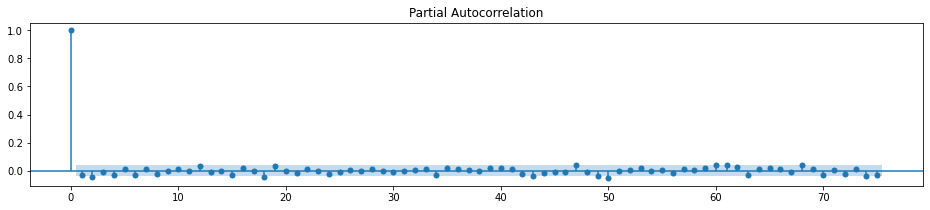

In [29]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(stationary, ax=ax, lags=75);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(stationary, ax=ax, lags=75);

Now that we believe we have a stationary model, let's attempt to split out a certain percentage of the data so that we can train and test split this to see how our model performs on unseen data.

Now that we have two buckets, we should also create some cross val folds so that we're able to check our model and tune it before sending in our test data.

It's pretty clear at this point in time that the previous day's stock price is the best indicator of the future price or today's price which is to be expected given how much a stock price is reactive to news at all different spectrums ie. globally, locally, company specific.

Let's now take a look at a baseline model which uses yesterday's stock price as a immediate prediction for future dates.

In [30]:
baseline = train.shift(1).dropna()
baseline

#This is just our prediction one day further, which is our baseline model.

Date
2006-01-04    17.45
2006-01-05    17.85
2006-01-06    18.35
2006-01-09    18.77
2006-01-10    19.06
              ...  
2015-08-03    28.42
2015-08-04    28.36
2015-08-05    28.03
2015-08-06    28.27
2015-08-07    28.21
Name: Close, Length: 2414, dtype: float64

In [31]:
# Calculating our RMSE here

np.sqrt(mean_squared_error(train[1:], baseline))

# On average we're .41c off the mark, that's not awful.


0.4153986117309533

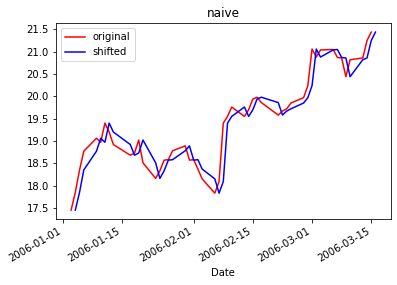

In [32]:
fig, ax = plt.subplots()
train[0:50].plot(ax=ax, c='r', label='original')
baseline[0:50].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

# Let's take a look at the residuals of each prediction

In [33]:
residuals = (train[1:] - baseline[1:]).dropna()
residuals

Date
2006-01-05    0.50
2006-01-06    0.42
2006-01-09    0.29
2006-01-10   -0.09
2006-01-11    0.43
              ... 
2015-08-03   -0.06
2015-08-04   -0.33
2015-08-05    0.24
2015-08-06   -0.06
2015-08-07   -0.06
Name: Close, Length: 2413, dtype: float64

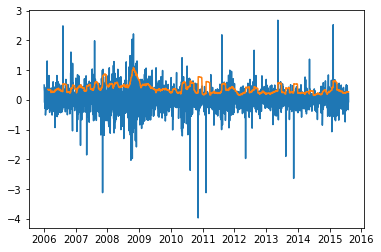

In [34]:
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());



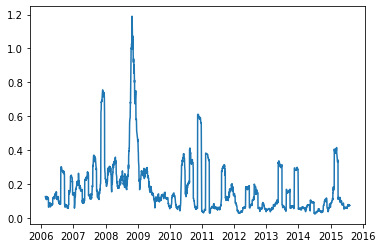

In [35]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

# Looks like we're always like 20-40c off on average however 2008 during the Financial crisis was
# an event that was unexplainable so it would have been extremely hard to predict that.
# Without that, it does look like we're quite stationary that is explained by the adfuller test
# we preformed earlier.

## ADD A LINE TO SHOW MOVEMENT

In [36]:
model_1 = ARIMA(train, order=(1,1,1)).fit()
ma_predict = model_1.predict(typ='levels')
ma_predict

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Date
2006-01-04    17.454381
2006-01-05    17.838765
2006-01-06    18.323048
2006-01-09    18.734751
2006-01-10    19.024042
                ...    
2015-08-03    28.416863
2015-08-04    28.361664
2015-08-05    28.046399
2015-08-06    28.273180
2015-08-07    28.216208
Length: 2414, dtype: float64

In [37]:
model_1_residual = (ma_predict-train).dropna()
print(model_1_residual)
abs(model_1_residual).mean()

Date
2006-01-04   -0.395619
2006-01-05   -0.511235
2006-01-06   -0.446952
2006-01-09   -0.325249
2006-01-10    0.054042
                ...   
2015-08-03    0.056863
2015-08-04    0.331664
2015-08-05   -0.223601
2015-08-06    0.063180
2015-08-07    0.066208
Length: 2414, dtype: float64


0.27884290475115486

In [38]:
train.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30',
               '2015-07-31', '2015-08-03', '2015-08-04', '2015-08-05',
               '2015-08-06', '2015-08-07'],
              dtype='datetime64[ns]', name='Date', length=2415, freq=None)

In [39]:
model_2 = ARIMA(train, order=(3,1,0)).fit()
ma_predict_2 = model_2.predict(typ='levels').dropna()

ma_predict_2

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Date
2006-01-04    17.454410
2006-01-05    17.842042
2006-01-06    18.320448
2006-01-09    18.734762
2006-01-10    19.031794
                ...    
2015-08-03    28.423667
2015-08-04    28.362238
2015-08-05    28.047358
2015-08-06    28.282309
2015-08-07    28.208847
Length: 2414, dtype: float64

In [40]:
model_2_residual = (ma_predict_2-train).dropna()
print(model_2_residual)
abs(model_2_residual).mean()

Date
2006-01-04   -0.395590
2006-01-05   -0.507958
2006-01-06   -0.449552
2006-01-09   -0.325238
2006-01-10    0.061794
                ...   
2015-08-03    0.063667
2015-08-04    0.332238
2015-08-05   -0.222642
2015-08-06    0.072309
2015-08-07    0.058847
Length: 2414, dtype: float64


0.278453647790967

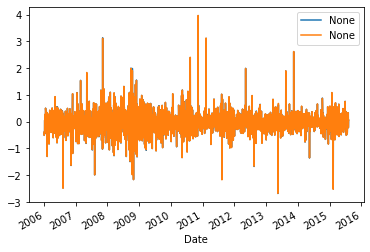

In [41]:
model_1_residual.plot(legend=True)
model_2_residual.plot(legend=True);

In [42]:
# print(np.sqrt(mean_squared_error(train, ma_predict_2)))
# print(np.sqrt(mean_squared_error(train, ma_predict)))


In [43]:
model_2 = ARIMA(train, order=(3,1,0)).fit()
ma_predict_2 = model_2.predict(typ='levels').dropna()

ma_predict_2

ma_predict_5 = model_2.predict(start=2414, end=3017, typ='levels')
new_df = ma_predict_5.reset_index()
new_df.rename(columns={0: 'Close'}, inplace=True)

new_df = new_df.set_index(test.index)
new_df.drop('index', inplace=True, axis=1)
new_df = pd.Series(new_df['Close'], index=test.index)
type(new_df)

new_df

resids = new_df - test
# resids


/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/st

In [44]:
print(np.sqrt(mean_squared_error(test, ma_predict_5)))

2.6999938646064985


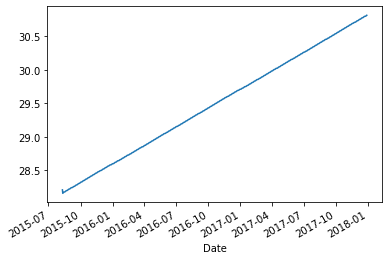

In [45]:
# resids.plot();
# test.plot();
new_df.plot();

This is a bit concerning here. As the price changes and is getting bigger, it looks like our prediction has zero shot of accounting for that. I need to look into why that is occuring.

This is also concerning beacuse it looks like our predictions are just tailing off at a certain point. I wonder why that is occuring.

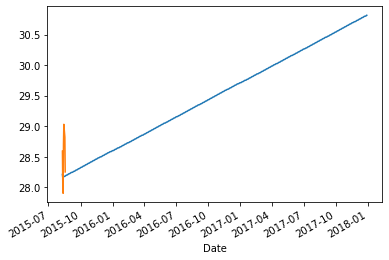

In [46]:
test_index = test[:7].index
test_values = test[:7]
len(test_values)

# resids.plot();

new_df.plot();
test_values.plot();

In [47]:
ma_predict_5 = model_2.predict(start=2414, end=2420, typ='levels')
new_df = ma_predict_5.reset_index()
new_df.rename(columns={0: 'Close'}, inplace=True)

new_df = new_df.set_index(test_index)
new_df.drop('index', inplace=True, axis=1)
new_df = pd.Series(new_df['Close'], index=test_index)
type(new_df)

new_df

resids = new_df - test_values
resids

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Date
2015-08-10   -0.381153
2015-08-11    0.137369
2015-08-12    0.265163
2015-08-13   -0.530103
2015-08-14   -0.855882
2015-08-17   -0.641510
2015-08-18   -0.067093
Name: Close, dtype: float64

Maybe a new section in Adam's notebook. 

We were looking at this poorly. We were trying to predict the stock price for 600 days out however if we think about this logically, it's nearly impossible to predict the future of a stock price 2 years out. Obviously we can try and model it and it would indicate the model to buy given the price has risen, however we wouldn't want that. Let's try predicting stock prices for 5 days out and seeing how our model performs when we'd want to either purchase or sell depending on our stocks prediction vs. the actual price.

I think it'll be interesting to create different buckets of 7 days so we can test our model over, let's say, 7 periods. That is totally time dependent and we'll just use the first 7 days and second fi

In [48]:
first_test = test[:7]
print(first_test)
last_test = test[-7:]
print(last_test)

Date
2015-08-10    28.59
2015-08-11    28.02
2015-08-12    27.90
2015-08-13    28.70
2015-08-14    29.03
2015-08-17    28.82
2015-08-18    28.25
Name: Close, dtype: float64
Date
2017-12-20    38.74
2017-12-21    38.53
2017-12-22    38.55
2017-12-26    38.48
2017-12-27    38.56
2017-12-28    38.59
2017-12-29    38.30
Name: Close, dtype: float64


NOT SURE WHAT TO DO FROM HERE:

downsize data - per week or per month



Let's try working on a super naive model where we just use the mean of the entire training data to calculate the mean and then predict that for the entire testing data. This will serve as our baseline model that we end up using to try and improve over the course of the time series work.

In [49]:
train.describe()

count    2415.000000
mean       22.468215
std         4.094399
min        13.620000
25%        19.285000
50%        22.560000
75%        25.405000
max        34.080000
Name: Close, dtype: float64

Looks like the mean over the training data is 22.468215 - let's use that to project the testing data and see how that performs in terms of average RMSE.



In [50]:
## Baseline Model

naive_mean_first = train.mean()
naive_prediction_first = np.repeat(naive_mean_first, len(first_test))



naive_rmse_first = mean_squared_error(first_test, naive_prediction_first, squared=False)
print(f' The RMSE for the first week long period is {naive_rmse_first}')


naive_mean_last = train.mean()
naive_prediction_last = np.repeat(naive_mean_last, len(last_test))



naive_rmse_last = mean_squared_error(last_test, naive_prediction_last, squared=False)
print(f' The RMSE for the first week long period is {naive_rmse_last}')


 The RMSE for the first week long period is 6.017465137013351
 The RMSE for the first week long period is 16.0679620554882


The RMSE here is pretty poor! We'd certainly hate being this off for stock predictions. Let's take a look at the summary results here and see how our AIC and BIC values compare to each other. It's certainly important to see that the model consistently gets significantly worse as time goes on. This is clear to the model not learning from prior results and as the price deviates from the last price the training model average gave us, we'll continue to move in a worse direction.

In [51]:
# ALarsen to figure out how to add the summary for the shit models to get results, not entirely
# sure how to do this.

train

Date
2006-01-03    17.45
2006-01-04    17.85
2006-01-05    18.35
2006-01-06    18.77
2006-01-09    19.06
              ...  
2015-08-03    28.36
2015-08-04    28.03
2015-08-05    28.27
2015-08-06    28.21
2015-08-07    28.15
Name: Close, Length: 2415, dtype: float64

In [52]:
first_model = ARIMA(train, order=(1,1,1)).fit()

first_prediction = first_model.predict(start=2415, end= 2421, typ='levels').dropna()
first_prediction = first_prediction.reset_index()
first_prediction.rename(columns={0: 'Close'}, inplace=True)
first_prediction = first_prediction.set_index(test[:7].index)
first_prediction.drop('index', inplace=True, axis=1)
first_prediction = pd.Series(first_prediction['Close'], index=first_test.index)


resids = first_prediction - first_test
print(resids)

first_model_first_rmse = mean_squared_error(first_test, first_prediction, squared=False)
print(first_model.summary())

print(first_model_first_rmse)

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Date
2015-08-10   -0.431615
2015-08-11    0.145479
2015-08-12    0.271699
2015-08-13   -0.522675
2015-08-14   -0.847450
2015-08-17   -0.632497
2015-08-18   -0.057728
Name: Close, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2414
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1300.559
Method:                       css-mle   S.D. of innovations              0.415
Date:                Thu, 06 Jan 2022   AIC                           2609.117
Time:                        08:11:31   BIC                           2632.273
Sample:                             1   HQIC                          2617.539
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const     

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [71]:
second_model = ARIMA(train, order=(2,1,2)).fit()

second_prediction = second_model.predict(start=2415, end= 2421, typ='levels').dropna()
second_prediction = second_prediction.reset_index()
second_prediction.rename(columns={0: 'Close'}, inplace=True)
second_prediction = second_prediction.set_index(test[:7].index)
second_prediction.drop('index', inplace=True, axis=1)
second_prediction = pd.Series(second_prediction['Close'], index=first_test.index)


resids = second_prediction - first_test
print(resids)

second_model_first_rmse = mean_squared_error(first_test, second_prediction, squared=False)
print(second_model.summary())

print(second_model_first_rmse)

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Date
2015-08-10   -0.425963
2015-08-11    0.147589
2015-08-12    0.276579
2015-08-13   -0.520329
2015-08-14   -0.843571
2015-08-17   -0.630249
2015-08-18   -0.054562
Name: Close, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2414
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1298.932
Method:                       css-mle   S.D. of innovations              0.414
Date:                Thu, 06 Jan 2022   AIC                           2609.864
Time:                        08:37:18   BIC                           2644.598
Sample:                             1   HQIC                          2622.496
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const     

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [69]:
third_model = ARIMA(train, order=(7,1,7)).fit()

third_prediction = third_model.predict(start=2415, end= 2421, typ='levels').dropna()
third_prediction = third_prediction.reset_index()
third_prediction.rename(columns={0: 'Close'}, inplace=True)
third_prediction = third_prediction.set_index(test[:7].index)
third_prediction.drop('index', inplace=True, axis=1)
third_prediction = pd.Series(third_prediction['Close'], index=first_test.index)


resids = third_prediction - first_test
print(resids)

third_model_first_rmse = mean_squared_error(first_test, third_prediction, squared=False)
print(third_model.summary())

print(third_model_first_rmse)

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


KeyboardInterrupt: 

In [55]:
fourth_model = ARIMA(train, order=(8,1,8)).fit()

fourth_prediction = fourth_model.predict(start=2415, end= 2421, typ='levels').dropna()
fourth_prediction = fourth_prediction.reset_index()
fourth_prediction.rename(columns={0: 'Close'}, inplace=True)
fourth_prediction = fourth_prediction.set_index(test[:7].index)
fourth_prediction.drop('index', inplace=True, axis=1)
fourth_prediction = pd.Series(fourth_prediction['Close'], index=first_test.index)


resids = fourth_prediction - first_test
print(resids)

fourth_model_first_rmse = mean_squared_error(first_test, fourth_prediction, squared=False)
print(fourth_model.summary())

print(fourth_model_first_rmse)

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: Conver

Date
2015-08-10   -0.398081
2015-08-11    0.159636
2015-08-12    0.291088
2015-08-13   -0.476641
2015-08-14   -0.815864
2015-08-17   -0.592288
2015-08-18   -0.119279
Name: Close, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2414
Model:                 ARIMA(8, 1, 8)   Log Likelihood               -1292.724
Method:                       css-mle   S.D. of innovations              0.413
Date:                Thu, 06 Jan 2022   AIC                           2621.449
Time:                        08:13:07   BIC                           2725.651
Sample:                             1   HQIC                          2659.346
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const     

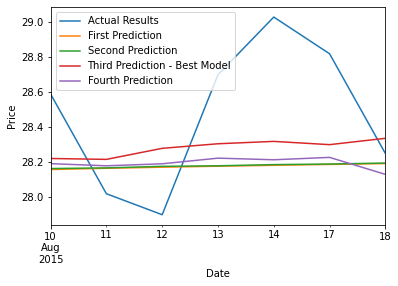

In [77]:
fig, ax = plt.subplots()
first_test.plot();
first_prediction.plot()
second_prediction.plot()
third_prediction.plot()
fourth_prediction.plot();
ax.legend(['Actual Results' 
           ,'First Prediction', 'Second Prediction', 'Third Prediction - Best Model', 'Fourth Prediction']);
ax.set_ylabel('Price');

This is a bit interesting. Knowing the price on the 7th of August 2015 which was roughly 28.15, our best performing model would have predicted the price would have increased to 28.33 indicating that the institutional investor should buy and hold until the 18th which is where our prediction ended given restraints in Time Series modeling. Despite being off by 0.08 cents which can mean making or losing a lot of money, it's certainly important to note that our model correctly predicted the direction of movement the stock so we would have had a winning trade but made less than we thought.

